In [2]:
import geopandas as gpd
import pandas as pd
import pyproj
import shapely
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import geopick as gp
import ipywidgets as widgets
import sys

random_seed = 42

#### In the text area below, enter your WKT or use the one by default

In [12]:
import ipywidgets as widgets
from IPython.display import display

# Create a Textarea widget
textarea_input = widgets.Textarea(
    value='',
    placeholder='Paste your text here',
    # description='WKT:',
    disabled=False,
    layout={'width': '800px', 'height': '300px'}  # Set width and height
)
def clear_wkt_textarea(b):
    # Clear the Textarea by setting its value to an empty string
    textarea_input.value = ""

button = widgets.Button(description="Clear WKT")
button.on_click(clear_wkt_textarea)
box = widgets.VBox([button, textarea_input], layout=widgets.Layout(align_items='flex-start'))

# f_wkt = "../data/capdecreus.txt"
f_wkt = "../data/wkt_different_than_geopickR.txt"
location_wkt = textarea_input.value
location_wkt = pathlib.Path(f_wkt).read_text()
textarea_input.value = location_wkt

display(box)

#### Import WKT

In [14]:
def extract_wkt(items):  
  wkt = None
  for item in items:
    if item.startswith("POINT") or item.startswith("LINESTRING") or \
      item.startswith("MULTILINESTRING") or item.startswith("POLYGON") or \
      item.startswith("MULTIPOLYGON"):
        wkt = item
        break  # Stop searching once a match is found
  return wkt
items = textarea_input.value.split("\t")
location_wkt = extract_wkt(items)

if location_wkt.startswith("POINT"):
  if(len(items) == 1):
    print("POINT geometry, uncertainty not specified.\n")
  else:
    print("POINT geometry.\n")
    print("Latitude:", items[0], ", Longitude:", items[1], ", Uncertainty:", items[3])
  class StopExecution(Exception):
   def _render_traceback_(self):
    return []
  raise StopExecution

#### Build location geometry (WGS84)

<Axes: >

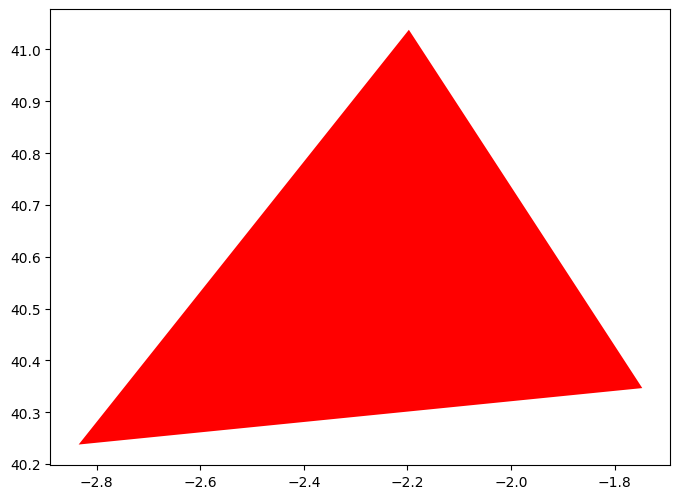

In [17]:
location_wgs84 = gpd.GeoSeries(shapely.wkt.loads(location_wkt))
location_wgs84.crs = "EPSG:4326"

sec_wgs84 = gp.get_sec(location_wgs84)
centroid_wgs84 = gp.get_sec_centroid(sec_wgs84, 4326)

fig, ax = plt.subplots(figsize=(8, 8))
location_wgs84.plot(aspect = "equal", color = "red", ax = ax)

#### Project location to parameterized AEQD and calculate centroid

<Axes: >

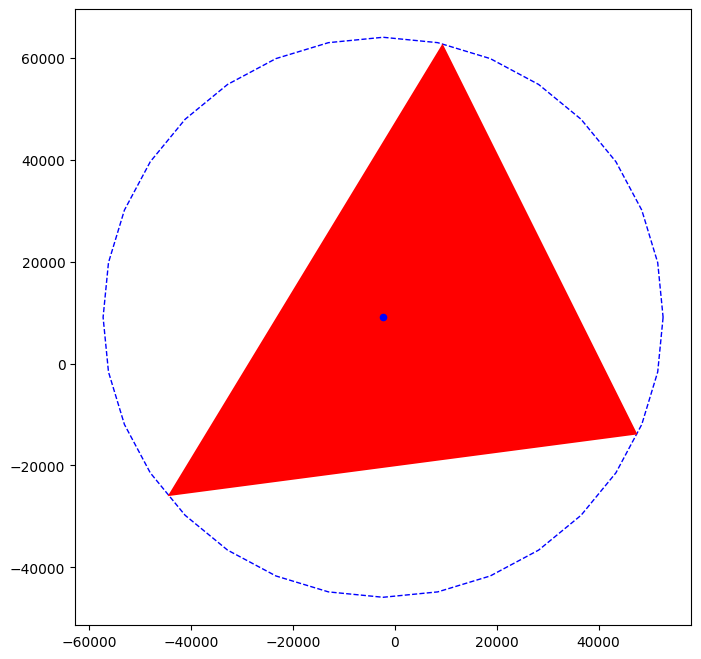

In [18]:
proj_aeqd = gp.get_aeqd_proj(location_wgs84)
location_aeqd = location_wgs84.to_crs(proj_aeqd)
sec_aeqd = gp.get_sec(location_aeqd)
centroid_aeqd = gp.get_sec_centroid(sec_aeqd, 4326)

fig, ax = plt.subplots(figsize=(8, 8))
sec_aeqd.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)

## Eventual geometry simplification

In [19]:
max_points_polygon =10000
tolerance = 500
location_aeqd = gp.simplify_geometry(location_aeqd)

<Axes: >

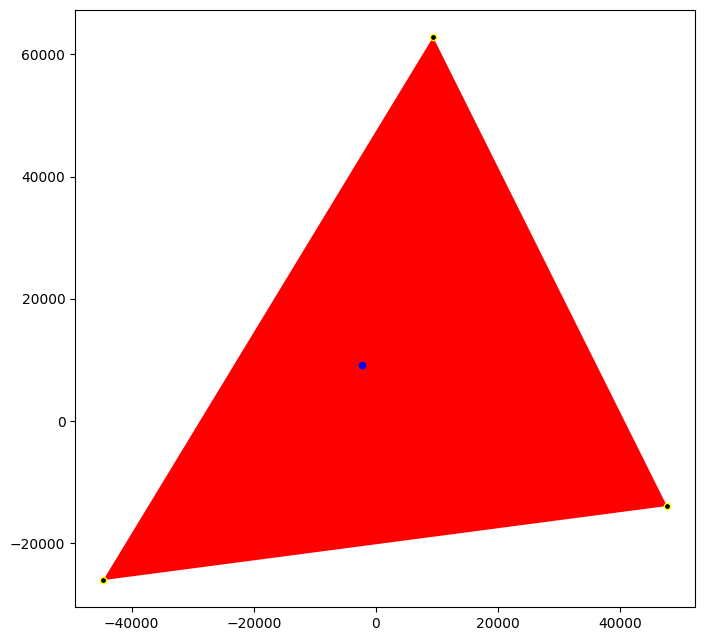

In [20]:
vertices = gp.get_all_vertices(location_aeqd)
fig, ax = plt.subplots(figsize=(8, 8))
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)

<Axes: >

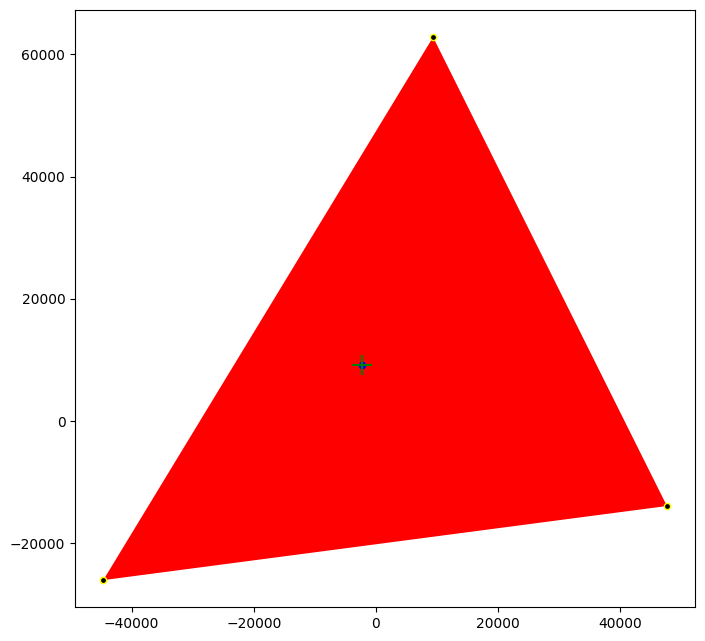

In [21]:
np = gp.get_nearest_point(centroid_aeqd, location_aeqd, proj_aeqd)

fig, ax = plt.subplots(figsize=(8, 8))
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)

## First approximation

<Axes: >

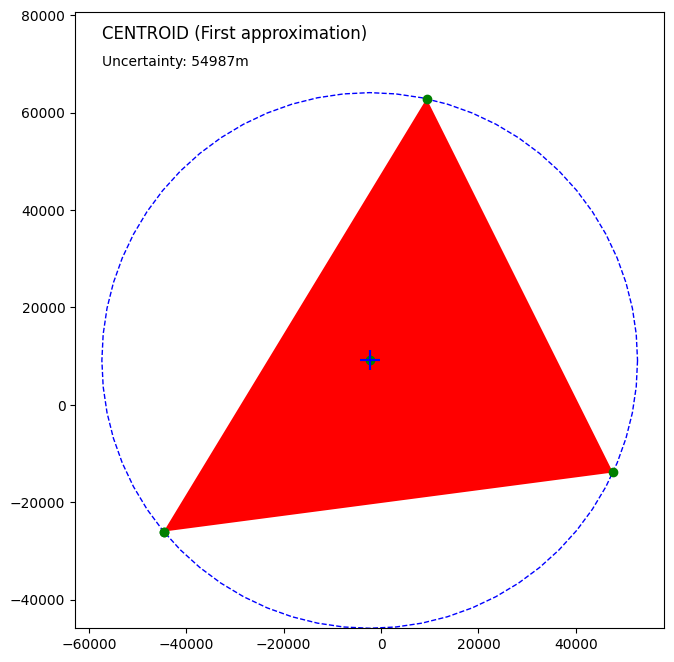

In [22]:
candidates = gp.get_candidate_vertices(vertices)
candidates = pd.concat([candidates, np])
candidates = candidates.reset_index(drop=True)

fa = gp.get_minimum_distance_candidate(candidates, vertices)
centroid_fa = gpd.GeoSeries(fa[0])
centroid_fa.crs = proj_aeqd
radius_fa = fa[1]
sec_fa = gpd.GeoSeries(centroid_fa.buffer(radius_fa))
sec_fa.crs = proj_aeqd

bounds = sec_fa.bounds
minx = bounds["minx"].iloc[0]
maxx = bounds["maxx"].iloc[0]
miny = bounds["miny"].iloc[0]
maxy = bounds["maxy"].iloc[0]
y_range = maxy - miny
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(miny, maxy + 0.15 * y_range)
ax.text(minx, maxy + 0.1 * y_range, 'CENTROID (First approximation)', fontsize=12, color='black')
ax.text(minx, maxy + 0.05 * y_range, f"Uncertainty: {radius_fa:.0f}m", fontsize=10, color='black')
sec_fa.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)
candidates.plot(aspect = "equal", color = "green", ax = ax)
centroid_fa.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)


## Second approximation


/Users/arnald/Library/CloudStorage/OneDrive-UAB/wb/GeoPick/py/geopick.py:92: UserWarning: The indices of the two GeoSeries are different.
  distances = point.distance(vertices)


<Axes: >

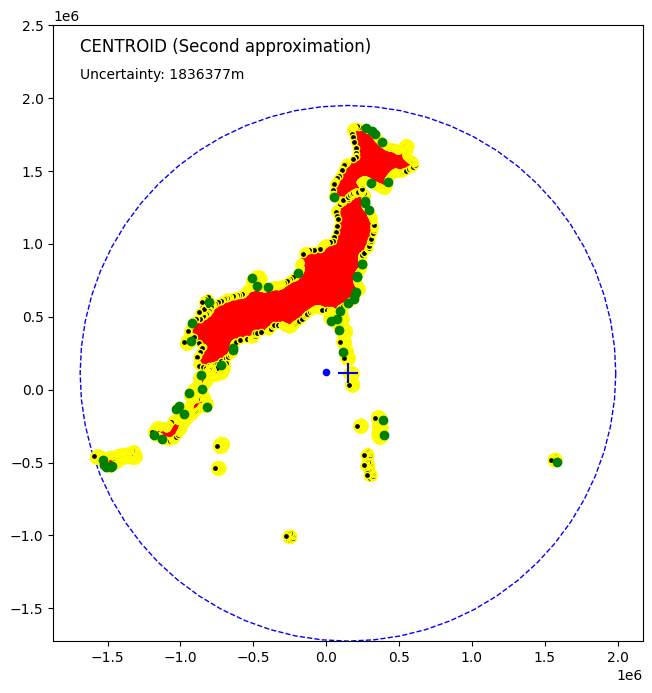

In [10]:
np_centroid_fa = gp.get_nearest_n_vertices(vertices, centroid_fa, 10)
sa = gp.get_minimum_distance_candidate(np_centroid_fa, vertices)
centroid_sa = gpd.GeoSeries(sa[0])
centroid_sa.crs = proj_aeqd
radius_sa = sa[1]
sec_sa = gpd.GeoSeries(centroid_fa.buffer(radius_sa))
sec_sa.crs = proj_aeqd


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(miny, maxy + 0.15 * y_range)
ax.text(minx, maxy + 0.1 * y_range, 'CENTROID (Second approximation)', fontsize=12, color='black')
ax.text(minx, maxy + 0.05 * y_range, f"Uncertainty: {radius_sa:.0f}m", fontsize=10, color='black')
sec_fa.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
location_aeqd.plot(aspect = "equal", color = "red", ax = ax)
vertices.plot(aspect = "equal", color = "yellow", facecolors = "black", markersize = 20, ax = ax)
centroid_aeqd.plot(aspect = "equal", color = "blue", markersize = 20, ax = ax)
np.plot(aspect = "equal", color = "green", marker="+", markersize = 200, ax = ax)
candidates.plot(aspect = "equal", color = "green", ax = ax)
np_centroid_fa.plot(aspect = "equal", color = "yellow", ax = ax)
centroid_fa.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)

## Final result

<Axes: >

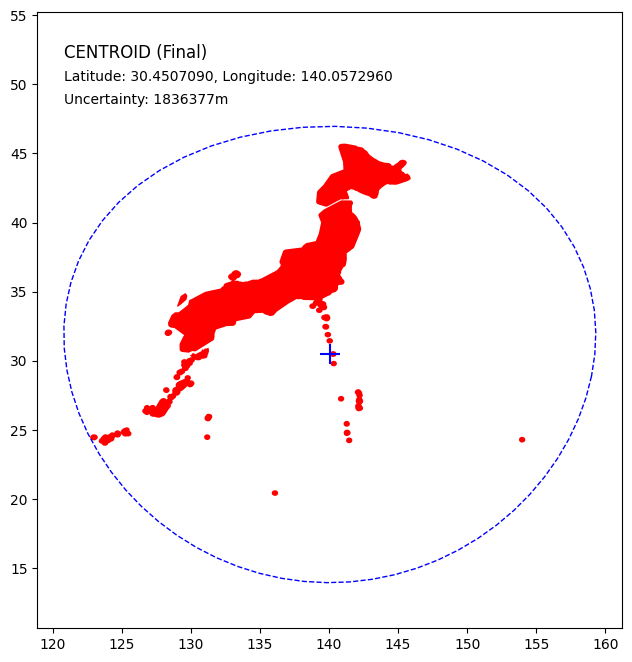

In [11]:
if(radius_sa < radius_fa):
  sec_final = sa
else:
  sec_final = fa

centroid_final = gpd.GeoSeries(sec_final[0])
centroid_final.crs = proj_aeqd
radius_final = sec_final[1]
sec_final = gpd.GeoSeries(centroid_final.buffer(radius_final))
centroid_final = centroid_final.to_crs(4326)
sec_final = sec_final.to_crs(4326)
centroid_final_coords = centroid_final.get_coordinates()
centroid_string = f"Latitude: {centroid_final_coords['y'].iloc[0]:.7f}, \
Longitude: {centroid_final_coords['x'].iloc[0]:.7f}"

bounds = sec_final.bounds
minx = bounds["minx"].iloc[0]
maxx = bounds["maxx"].iloc[0]
miny = bounds["miny"].iloc[0]
maxy = bounds["maxy"].iloc[0]
y_range = maxy - miny

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim(miny - 0.1 * y_range, maxy + 0.25 * y_range)
ax.text(minx, maxy + 0.15 * y_range, 'CENTROID (Final)', fontsize=12, color='black')
ax.text(minx, maxy + 0.10 * y_range, centroid_string, fontsize=10, color='black')
ax.text(minx, maxy + 0.05 * y_range, f"Uncertainty: {radius_final:.0f}m", fontsize=10, color='black')

location_wgs84.plot(aspect = "equal", color = "red", ax = ax)
sec_final.plot(aspect = "equal", facecolor = "none", edgecolor = "blue", linestyle = "dashed", ax = ax)
centroid_final.plot(aspect = "equal", color = "blue", marker="+", markersize = 200, ax = ax)
